# 交叉验证
---



## 从零写交叉验证

1） 导入模块

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold  #主要用于K折交叉验证

2）导入数据

In [2]:
# 导入iris数据集
iris=datasets.load_iris()
X=iris.data
y=iris.target
print(X.shape,y.shape)
# 定义我们想要搜索的K值（候选集），这里定义8个不同的值
ks=[1,3,5,7,9,11,13,15]

(150, 4) (150,)


In [19]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

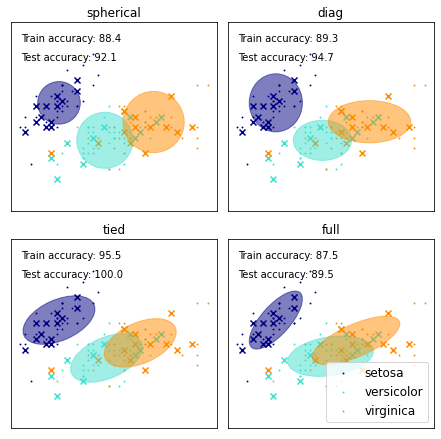

In [23]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

#print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

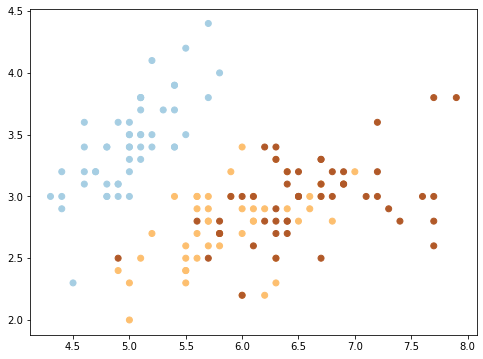

In [17]:
import matplotlib.pyplot as plt 
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(X[:, 0], X[:, 1],c=y, cmap=plt.cm.Paired)
plt.show()

3）应用

In [3]:
# 例：进行5折交叉验证，KFold返回的是每一折中训练数据和验证数据的index
# 假设数据样本为:[1,3,5,6,11,12,43,12,44,2],总共10个样本
# 则返回的kf的格式为（前面的是训练数据，后面的是验证数据）：
# [0,1,3,5,6,7,8,9],[2,4]
# [0,1,2,4,6,7,8,9],[3,5]
# [1,2,3,4,5,6,7,8],[0,9]
# [0,1,2,3,4,5,7,9],[6,8]
# [0,2,3,4,5,6,8,9],[1,7]
kf =KFold(n_splits=5,random_state=2001,shuffle=True)

# 保存当前最好的K值和对应的准确值
best_k=ks[0]
best_score=0

# 循环每一个K值
for k in ks:
    curr_score=0
    for train_index,valid_index in kf.split(X):
        #每一折的训练以及计算准确率
        clf=KNeighborsClassifier(n_neighbors=k)
        clf.fit(X[train_index],y[train_index])
        curr_score=curr_score+clf.score(X[valid_index],y[valid_index])
    #求5折的平均准确率
    avg_score=curr_score/5
    if avg_score>best_score:
        best_k=k
        best_score=avg_score
    print("现在的最佳准确率：%.2f"%best_score,"现在的最佳K值 %d"%best_k)

print("最终最佳准确率：%.2f"%best_score,"最终的最佳K值 %d"%best_k)

现在的最佳准确率：0.96 现在的最佳K值 1
现在的最佳准确率：0.96 现在的最佳K值 1
现在的最佳准确率：0.97 现在的最佳K值 5
现在的最佳准确率：0.98 现在的最佳K值 7
现在的最佳准确率：0.98 现在的最佳K值 7
现在的最佳准确率：0.98 现在的最佳K值 7
现在的最佳准确率：0.98 现在的最佳K值 7
现在的最佳准确率：0.98 现在的最佳K值 7
最终最佳准确率：0.98 最终的最佳K值 7


## 使用sklearn来实现同样的逻辑，只需要调用即可以实现K折交叉验证；

In [4]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV  #通过网络方式来获取参数

# 导入iris数据集
iris2=datasets.load_iris()
X2=iris2.data
y2=iris2.target
print(X2.shape,y2.shape)

# 设置需要搜索的K值，'n_neightbors'是sklearn中KNN的参数
parameters={'n_neightbors':[1,3,5,7,9,11,13,15]}
knn=KNeighborsClassifier()#注意：这里不用指定参数

# 通过GridSearchCV来搜索最好的K值。这个模块的内部其实就是对每一个K值进行评估
clf=GridSearchCV(knn,parameters,cv=5)  #5折
clf.fit(X2,y2)

# 输出最好的参数以及对应的准确率
print("最终最佳准确率：%.2f"%clf.best_score_,"最终的最佳K值",clf.best_params_)

(150, 4) (150,)


ValueError: Invalid parameter n_neightbors for estimator KNeighborsClassifier(). Check the list of available parameters with `estimator.get_params().keys()`.

In [8]:
#coding:utf-8
"""
sklearn 0.18
python 3
KNN参数调优
"""
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import input_data
import numpy as np

mnist = input_data.read_data_sets('mnist/',one_hot=False)
#小数据量加快gridsearch的速度
x = mnist.train.images[0:1000,:]
y = mnist.train.labels[0:1000]
train_data,validation_data,train_labels,validation_labels = train_test_split(x,y,test_size=0.1)

#开始调优使用GridSearchCV找到,最优参数
knn = KNeighborsClassifier()
#设置k的范围
k_range = list(range(1,10))
leaf_range = list(range(1,2))
weight_options = ['uniform','distance']
algorithm_options = ['auto','ball_tree','kd_tree','brute']
param_gridknn = dict(n_neighbors = k_range,weights = weight_options,algorithm=algorithm_options,leaf_size=leaf_range)
gridKNN = GridSearchCV(knn,param_gridknn,cv=10,scoring='accuracy',verbose=1)
gridKNN.fit(train_data,train_labels)
print('best score is:',str(gridKNN.best_score_))
print('best params are:',str(gridKNN.best_params_))


ModuleNotFoundError: No module named 'input_data'

In [7]:
pip install input_data


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement input_data
ERROR: No matching distribution found for input_data


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## 知识点
----
[1].[网格搜索（GridSearchCV](https://www.cnblogs.com/wj-1314/p/10422159.html)  
[2].[The iris 鳶尾花資料集](https://machine-learning-python.kspax.io/datasets/ex3_the_iris_dataset)  
[3].[Iris - 数据可视化](https://www.jianshu.com/p/3bb2cc453df1)
